In [1]:
#calcular parâmetros das galáxias
#EM CONSTRUÇÃO!
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import LogStretch
from matplotlib.colors import LogNorm
from astropy.modeling import models
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import photutils
import time
import statmorph

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

In [5]:
#Imagens
GHII = 'testeMrk1271.fits'
image_star = 'Mrk1271_psf.fits'
image_mask = 'flag.fits'
weight = 'weight.fits'

Filename: teste1011.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (101, 101)   float32   
[[-0.00970638 -0.01386469 -0.01193151 ... -0.00909443 -0.01452509
   0.01105367]
 [ 0.00077899  0.01340073  0.00962718 ...  0.00715011 -0.0099991
  -0.01447318]
 [-0.01518448 -0.01557323 -0.00770095 ... -0.01652522  0.01513007
   0.03318156]
 ...
 [-0.007238   -0.00974724 -0.01119468 ... -0.01118254 -0.00300659
  -0.0197832 ]
 [-0.01747962 -0.03229652 -0.01904845 ...  0.01389502  0.00474674
   0.01121755]
 [-0.01252708  0.00777796  0.00631285 ... -0.02138731 -0.00549649
   0.01233195]]
101


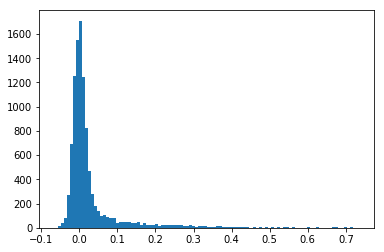

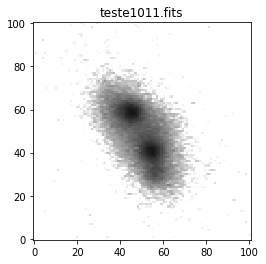

In [6]:
#Galáxia
filename = get_pkg_data_filename(GHII)
fits.info(filename)

galaxy = fits.open(filename)
image_data = galaxy[0].data

NBINS = 100
histogram = plt.hist(image_data.flatten(), NBINS) #histograma usado para saber os limites de pixel

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(filename)
print(image_data)
print(len(image_data))
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))
plt.savefig(GHII+'_ori.png')

Nível de fundo = 0.004684
Ruído de fundo = 0.021155
Nível de fundo sub = 0.000000
Ruído de fundo sub = 0.021155


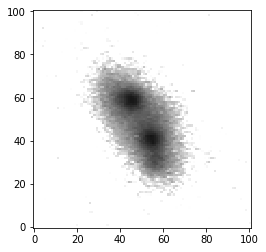

In [7]:
#Ruido de fundo e Nivel de fundo + limpeza da imagem
#mediana da imagem como nível de fundo e o desvio padrão da imagem como ruído de fundo 1-sigma. 
#image median as the background level and the image standard deviation as the 1-sigma background noise
from astropy.stats import mad_std
background_level = np.median(image_data)
print('Nível de fundo = %f'%(background_level))
background_noise = mad_std(image_data)
print('Ruído de fundo = %f'%(background_noise))
image_data-= background_level
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))
#plt.savefig(GHII+'_sub.png')
background_level = np.median(image_data)
print('Nível de fundo sub = %f'%(background_level))
background_noise = mad_std(image_data)
print('Ruído de fundo sub = %f'%(background_noise))
#Sem subtrair o fundo o resultado fica mais parecido com o obtido pelo IRAF.


#image_data.writeto( 'new_'+filename ) #Cria um fits novo já corrigido pelo ruido de fundo

[[0.07998265 0.0893965  0.08549071 ... 0.09446268 0.09445336 0.10429094]
 [0.07994936 0.07299888 0.08139584 ... 0.08257025 0.07906168 0.102481  ]
 [0.08562147 0.07576453 0.0815611  ... 0.10511307 0.09721982 0.09022421]
 ...
 [0.10283642 0.09590669 0.09113691 ... 0.09017175 0.0943616  0.07487042]
 [0.08697469 0.08854411 0.10943908 ... 0.08317754 0.09435278 0.07499403]
 [0.07834736 0.08846223 0.10091892 ... 0.10027763 0.08994874 0.08853078]]
101


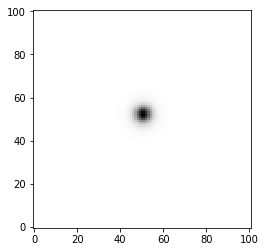

In [12]:
#Estrela PSF
psf = fits.open(image_star)
psf = psf[0].data
plt.imshow(psf, origin='lower', cmap='gray_r')
print(psf) #Matriz estrela
print(len(psf))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01113018 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
141


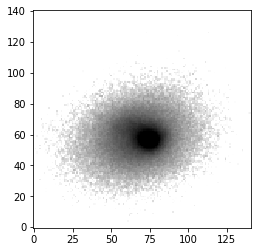

In [13]:
#mapa pixels - weight maps
m_pixel = fits.open(weight)
m_pixel = m_pixel[0].data
plt.imshow(m_pixel, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))
print(m_pixel) #Matriz mapa de pixel da galáxia
print(len(m_pixel))
plt.savefig(GHII+'_object.png')

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [False  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


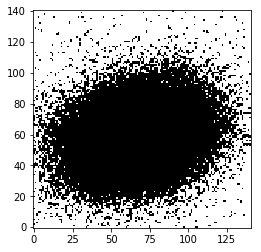

In [14]:
#Imagem mask. Estou usando o flag - TESTE
#A mascara é uma matriz booleana que determina os pixels a serem desconsiderados 
Mask = fits.open(image_mask)
Mask = Mask[0].data
Mask = Mask >= 1  #transforma em matriz booleana
plt.imshow(Mask, origin='lower', cmap='gray')
print(Mask)
plt.savefig(GHII+'_mask.png')

In [15]:
#convolução = Matriz de entrada e matriz PSF. Só serve para emular um seeing em uma imagem sintética
#image_data = ndi.convolve(image_data,weights=m_pixel) #usando a origem ,origin=[204,204] da erro
#plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1))

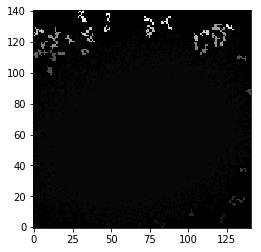

In [16]:
#O SExtractor é indicado para fazer o mapa de segmentação. Segmap
#Porém estou usando photutils para fazer um.
threshold = photutils.detect_threshold(image_data, snr=1.5)
npixels = 8  # minimum number of connected pixels
segm = photutils.detect_sources(image_data, threshold, npixels)
plt.imshow(segm, origin='lower', cmap='gray')

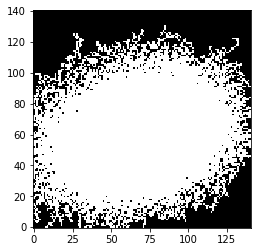

In [17]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

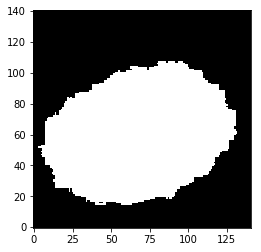

In [18]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.9
plt.imshow(segmap, origin='lower', cmap='gray')

plt.savefig(GHII+'_segment.png')

In [19]:
#Agora que temos todos os dados necessários
#Gain=1000.0 #Assumindo que existe uma média de mil elétrons / pixel no raio efetivo - gain=Gain
m_pixel #Ou Pode ser substituido(Gain) por uma matriz 2D weightmap=m_pixel, fornecida pelo SExtractor
start = time.time()
source_morphs = statmorph.source_morphology(image_data, segmap, weightmap=m_pixel, psf=psf, eta=0.2)
print('Time: %g s.' % (time.time() - start))

Finished processing source 1.

Time: 4.57341 s.


In [20]:
morph = source_morphs[0]
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
print('r50 em arcseg =',morph.r50*0.161)
print('Retorna o eixo semi-principal da elipse mínima =',morph.rmax_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz =',morph.rhalf_ellip) 

xc_centroid = 69.46575343566333
yc_centroid = 58.21934236356011
ellipticity_centroid = 0.28503621368114673
elongation_centroid = 1.3986722392594426
orientation_centroid = 0.22821361627711245
xc_asymmetry = 73.24105197538567
yc_asymmetry = 57.67178225177005
ellipticity_asymmetry = 0.2956994208149353
elongation_asymmetry = 1.4198483283331733
orientation_asymmetry = 0.19709933880684583
rpetro_circ = 35.62713413198577
rpetro_ellip = 43.372817692364805
rhalf_circ = 12.933662607879151
rhalf_ellip = 15.42469917571996
r20 = 5.585850887673038
r50 = 14.05530233137684
r80 = 27.67247202120416
Gini = 0.5547186863410988
M20 = -1.6289989140425192
F(G, M20) = -0.08524625518009543
S(G, M20) = -0.004259349574222471
sn_per_pixel = 0.8973399
C = 3.474793094176556
A = 0.4079072134848634
S = 0.0432927261971113
sersic_amplitude = 0.16528227020715347
sersic_rhalf = 24.55386510749486
sersic_n = 0.2179747931018923
sersic_xc = 67.03103377424394
sersic_yc = 56.32497941203902
sersic_ellip = 0.3195516354907574
sers

In [ ]:
print('Desvio estatistico =',morph.deviation) 

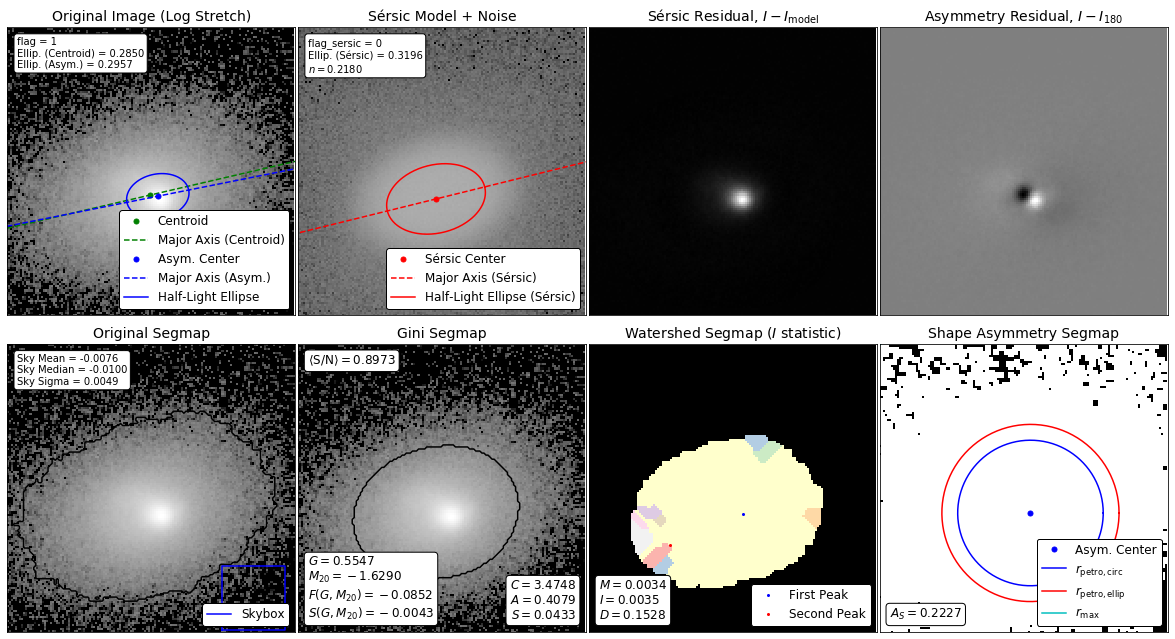

In [21]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
fig.savefig(GHII+'_morph.png', dpi=150)